# Сборный проект: 

## Введение  

Стартап, который продаёт продукты питания хочет разобраться, как ведут себя пользователи его мобильного приложения.  

**Цель:** изучить воронку продаж, узнать, как пользователи доходят до покупки. Исследовать результаты A/A/B-эксперимента по влиянию на пользователей изменение шрифта.  

Исследование проводится в пять этапов:  

1. Обзор данных  
2. Предобработка данных  
3. Изучение и проверка данных  
4. Изучение воронки событий  
5. Изучение результатов эксперимента  

## Обзор данных  

Ознакомимся с входными данными. 

In [2]:
# импортируем библиотеки

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import date
from matplotlib import pyplot as plt
from scipy import stats as st
import math as mth

In [3]:
# игнорируем предупреждения

import warnings
warnings.filterwarnings('ignore') 

In [4]:
# прочитаем файл с данными и сохраним его в переменную

data = pd.read_csv('/datasets/logs_exp.csv')
data.head()

,EventName\tDeviceIDHash\tEventTimestamp\tExpId
0,MainScreenAppear\t4575588528974610257\t1564029...
1,MainScreenAppear\t7416695313311560658\t1564053...
2,PaymentScreenSuccessful\t3518123091307005509\t...
3,CartScreenAppear\t3518123091307005509\t1564054...
4,PaymentScreenSuccessful\t6217807653094995999\t...


Все данные в таблице "склеины", нужно разделить на столбцы.

In [5]:
# делим данные на отдельные столбцы

data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
# выведем информацию по таблице

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В наличии следующие данные:  

- EventName — название события;  
- DeviceIDHash — уникальный идентификатор пользователя;  
- EventTimestamp — время события;  
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

### Вывод  

В таблице 4 столбца с данными по каждому действию пользователя: идентификатор пользователя, название события, время события, к какой группе теста относится позователь.  

Пропущенных значений нет.  

Названия столбцов и написание значений в столбцах нужно привести к единому стилю. Название групп теста лучше переименовать на более понятные.  

В столбце  EventTimestamp тип данных нужно поменять на datetime64.  

## Предобработка данных

- Переименуем столбцы

In [7]:
data = data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id_hash', 'EventTimestamp':'event_timestamp', 'ExpId':'exp_id'})
data.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

- Переименуем названия для событий и групп А/А/В теста

In [8]:
# для столбца event_name
data['event_name'] = data['event_name'].replace(['MainScreenAppear', 'PaymentScreenSuccessful','CartScreenAppear','OffersScreenAppear', 'Tutorial'],\
                                                ['main_screen_appear', 'payment_screen_successful','cart_screen_appear','offers_screen_appear', 'tutorial'])

# для столбца exp_id
data['exp_id'] = data['exp_id'].replace([246,247,248],['a1','a2','b'])
data.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,main_screen_appear,4575588528974610257,1564029816,a1
1,main_screen_appear,7416695313311560658,1564053102,a1
2,payment_screen_successful,3518123091307005509,1564054127,b
3,cart_screen_appear,3518123091307005509,1564054127,b
4,payment_screen_successful,6217807653094995999,1564055322,b


- Изменим тип данных для столбца event_timestamp на datetime64[ns]

In [9]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data.dtypes

event_name                 object
device_id_hash              int64
event_timestamp    datetime64[ns]
exp_id                     object
dtype: object

- Добавим столбец только с датой

In [10]:
data['data'] = data['event_timestamp'].dt.date.astype('datetime64')
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,data
0,main_screen_appear,4575588528974610257,2019-07-25 04:43:36,a1,2019-07-25
1,main_screen_appear,7416695313311560658,2019-07-25 11:11:42,a1,2019-07-25
2,payment_screen_successful,3518123091307005509,2019-07-25 11:28:47,b,2019-07-25
3,cart_screen_appear,3518123091307005509,2019-07-25 11:28:47,b,2019-07-25
4,payment_screen_successful,6217807653094995999,2019-07-25 11:48:42,b,2019-07-25


- Проверим дубликаты и удалим их

In [11]:
# найдем сумму явных дубликатов в таблицах

data.duplicated().sum()

413

In [12]:
# удалим дубликаты

data = data.drop_duplicates().reset_index(drop=True)

### Вывод  

Переименовали названия столбцов и значения в столбце event_name, привели к единому стилю написания. Заменили названия тестовых групп на понятные: а1, а2 и b.  

Изменили тип данных в столбце event_timestamp на datetime64 и добавили новый столбец только с датой.  

Удалили 413 явных дубликатов.

## Изучение и проверка данных  

- **Узнаем сколько всего событий и пользователей в логе, а также сколько в среднем событий приходится на пользователя**

In [13]:
# выведем кол-во уникальных значений для столбца device_id_hash и общее кол-во событий

display(data['device_id_hash'].nunique())
display(data['event_name'].count())

7551

243713

In [14]:
# рассчитаем медианное и среднее значение событий для одного пользователя

display(data.groupby('device_id_hash')['event_name'].count().median())
display(data.groupby('device_id_hash')['event_name'].count().mean())

20.0

32.27559263673685

В среднем приходится 32 события на пользователя, но медианное значение равно 20, следовательно есть аномально большые значения кол-ва событий, которые влияют на среднее.

- **Найдем максимальную и минимальную дату**

In [15]:
display(data['data'].min())
display(data['data'].max())

Timestamp('2019-07-25 00:00:00')

Timestamp('2019-08-07 00:00:00')

Мы располагаем данными с 25 июля 2019 года по 7 августа 2019 года.

- **Посмотрим на данные, определим за какой период данные более полные**

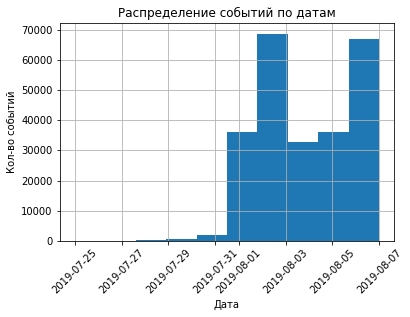

In [16]:
# построим гистограмму по столбцу data

data['data'].hist()
plt.xticks(rotation=45)
plt.title('Распределение событий по датам')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий');

На графике видно, что за период с 25 июля по 1 августа данных очень мало, поэтому их можно отбросить и не использовать в исследовании. Будем использовать данные только с 1 августа по 7 августа.

In [17]:
# создадим новую таблицу с данными после 1 августа

data_new = data.query('data >= "2019-08-01"')

# выведем кол-во событий в исходной и новой таблицах
display(data_new.shape[0])
display(data.shape[0])

240887

243713

In [18]:
# посчитаем кол-во уникальных пользователей в новой таблице
display(data_new['device_id_hash'].nunique())

7534

Отбросив данные за первую неделю эксперимента мы потеряли около 3000 событий, что составляет чуть больше одного процента от общего кол-ва событий. Кол-во уникальных пользователей сократилось на 17 человек.  

Проверим, что у нас остались пользователи из всех трех экспериментальных групп.

In [19]:
data_new.groupby('exp_id')['device_id_hash'].count()

exp_id
a1    79302
a2    77022
b     84563
Name: device_id_hash, dtype: int64

### Вывод  

В среднем на одного пользователя приходится 32 события, медианное кол-во событий на пользователя равно 20. Такая разница говорит о том, что в данных присутствуют аномально большие значения кол-ва событий для некоторых пользователей.  

Данные представленны за период с 25 июля по 7 августа 2019 года. Определили, что до 1 августа данных было собрано очень мало, поэтому исключим этот период из исследования. Это не повлияет на результыты, так как кол-во событий до 1 августа составляют чуть больше 1% от общего кол-ва.  

Для исследования возьмем период с 1 по 7 августа 2019 года.

## Изучение воронки событий

- **Проанализируем события в логах**

In [20]:
# посчитаем общее кол-во уникальных пользователей
count_id = data['device_id_hash'].nunique()
count_id

# создадим сводную, в которую запишем кол-во каждого события и кол-во уникальных пользователей его совершивших
data_pivot = data_new.pivot_table(index='event_name', values='device_id_hash', aggfunc=['count', 'nunique'])

# добавим столбец с процентом пользователей, совершивших определенное действие относительно общего кол-ва уникальных пользователей
data_pivot['percent'] = data_pivot[('nunique', 'device_id_hash')]/count_id*100

# отсортируем по убыванию кол-ва пользователей по событиям и округлим значения
data_pivot.sort_values(by=('nunique', 'device_id_hash'), ascending=False).round(2)

,count,nunique,percent
,device_id_hash,device_id_hash,
event_name,,,
main_screen_appear,117328,7419,98.25
offers_screen_appear,46333,4593,60.83
cart_screen_appear,42303,3734,49.45
payment_screen_successful,33918,3539,46.87
tutorial,1005,840,11.12


- **Посчитаем, какая доля пользователей проходит на следующий шаг воронки**

In [21]:
# создадим сводную таблицу без события tutorial
data_pivot_2 = data_new.query('event_name != "tutorial"')\
                       .pivot_table(index='event_name', values='device_id_hash', aggfunc=['count', 'nunique'])\
                       .sort_values(by=('nunique', 'device_id_hash'), ascending=False).reset_index()

# создадим список из столбца nunique device_id_hash
nunique_device_id_hash = data_pivot_2[('nunique', 'device_id_hash')].tolist()

# создадим функцию, которая посчитает процент по каждому шагу относительно первого действия
conversion_1 = [100]

for i in range(len(nunique_device_id_hash)):
    conversion_1.append(nunique_device_id_hash[i]/nunique_device_id_hash[0]*100)
    
conversion_1.pop(1)

# создадим функцию, которая посчитает процент по каждому шагу относительно предыдущего действия
conversion_2 = [100]
for i in range(len(nunique_device_id_hash)):
    conversion_2.append(nunique_device_id_hash[i]/nunique_device_id_hash[i-1]*100)
    
conversion_2.pop(1)

#добавим столбцы с процентами пользователей, которые переходят на следующий шаг
data_pivot_2['percent_1'] = conversion_1 #от первого события
data_pivot_2['percent_2'] = conversion_2 #от предыдущего шага
data_pivot_2.round()

,event_name,count,nunique,percent_1,percent_2
,,device_id_hash,device_id_hash,,
0,main_screen_appear,117328,7419,100.0,100.0
1,offers_screen_appear,46333,4593,62.0,62.0
2,cart_screen_appear,42303,3734,50.0,81.0
3,payment_screen_successful,33918,3539,48.0,95.0


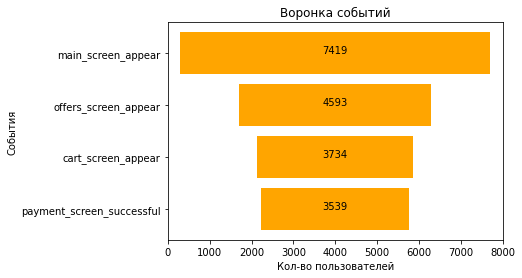

In [22]:
# создадим список из столбца event_name
event_name = data_pivot_2[('event_name','')].tolist()

# создадим график воронки событий
y = list(reversed(event_name))
x = list(reversed(nunique_device_id_hash))
x_max = 8000
x_min = 0
for idx, val in enumerate(x):
    left = (x_max - val)/2
    plt.barh(y[idx], x[idx], left = left, color='orange')
    plt.text(4000, y[idx], x[idx], ha='center')

plt.xlim(x_min, x_max)
plt.title('Воронка событий')
plt.xlabel('Кол-во пользователей')
plt.ylabel('События');

Из всех зашедших на сайт пользователей только 48% совершили покупку.

На графике и в таблице видно, что больше всего пользователей теряется на втором шаге, по какой-то причине после входа на главную страницу некоторые пользователи так и не переходят на карточку товара, возможно они не могут найти нужный им товар.   

81% пользователей добавляют товар в корзину после того, как они перешели на карточку товара, и 95% оплачивают товар после добавления в корзину.

### Вывод  

При покупке товаров в приложении пользователи совершают определенную последовательность действий, которую нельзя изменить:  
заходят на главную страницу сайта ---> открывают карточку товара ---> добавляют его в корзину ---> оплачивают товар.  
Также в приложении можно посмотреть инструкцию о том, как сделать заказ.  

Из всех уникальных пользователей, только 48% завершают заказ и оплачивают товар. Большинство теряется на шаге перехода на карточку товара. Процент добавления в корзину - 81%, а оплаты - 95%.  

Можно предположить, что на втором шаге у пользователя возникают проблемы с поиском необходимого товара.  

## Изучение результатов эксперимента

In [23]:
# посмотрим сколько пользователей в каждой экспериментальной группе
data_new.groupby('exp_id')['device_id_hash'].nunique()

exp_id
a1    2484
a2    2513
b     2537
Name: device_id_hash, dtype: int64

In [24]:
# создадим список с общим кол-вом пользователей в каждой группе
list_count = data_new.groupby('exp_id')['device_id_hash'].nunique().tolist()

# создадим сводную таблицу действий по каждой группе
data_groups = data_new.query('event_name != "tutorial"')\
                      .pivot_table(index='event_name',columns='exp_id', values='device_id_hash', aggfunc='nunique')\
                      .sort_values(by=('a1'), ascending=False)\
                      .reset_index()

#добавим столбцы с процентами по каждой группе относительно общего кол-ва 
data_groups['percent_a1'] = data_groups['a1']/list_count[0]*100
data_groups['percent_a2'] = data_groups['a2']/list_count[1]*100
data_groups['percent_b'] = data_groups['b']/list_count[2]*100

data_groups.round()

exp_id,event_name,a1,a2,b,percent_a1,percent_a2,percent_b
0,main_screen_appear,2450,2476,2493,99.0,99.0,98.0
1,offers_screen_appear,1542,1520,1531,62.0,60.0,60.0
2,cart_screen_appear,1266,1238,1230,51.0,49.0,48.0
3,payment_screen_successful,1200,1158,1181,48.0,46.0,47.0


In [27]:
#  КОД РЕВЬЮЕРА

data_new.groupby('exp_id')['device_id_hash'].count()

exp_id
a1    79302
a2    77022
b     84563
Name: device_id_hash, dtype: int64

In [28]:
# напишем функицию для z_test

def z_test (list_1, list_2, list_3, list_4):
    
    alpha = 0.01
    
    successes = np.array([list_1, list_2])
    trials = np.array([list_3, list_4])
    
    # доля пользователей от ощего кол-ва в первом тесте:
    p1 = successes[0]/trials[0]
    
    # доля пользователей от ощего кол-ва во втором тесте:
    p2 = successes[1]/trials[1]
    
    # доля пользователей в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # посчитаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # зададим стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

- **С помощью z-теста проверим, есть ли статистические критерии разницы между выборками а1 и а2**  

**Нулевые гипотезы:**  
- доли пользователей в группах а1 и а2, зашедших на главную страницу, равны 
- доли пользователей в группах а1 и а2, перешедших на карточку товара, равны
- доли пользователей в группах а1 и а2, положивших заказ в корзину, равны
- доли пользователей в группах а1 и а2, оплативших товар, равны

**Альтернативные гипотезы:**  
- доли пользователей в группах а1 и а2, зашедших на главную страницу, не равны 
- доли пользователей в группах а1 и а2, перешедших на карточку товара, не равны
- доли пользователей в группах а1 и а2, положивших заказ в корзину, не равны
- доли пользователей в группах а1 и а2, оплативших товар, не равны

**Проверка гипотезы:** посчитаем и сравним доли для групп а1 и а2. Уровень статистической значимости зададим в 1%.

In [29]:
# создадим из столбцов списки
a1_list = data_groups['a1'].tolist()
a2_list = data_groups['a2'].tolist()

# проведем z-test для групп а1 и а2
print('Для захода на главную страницу:')
z_test(a1_list[0], a2_list[0], list_count[0], list_count[1])
print()

print('Для перехода на карточку товара:')
z_test(a1_list[1], a2_list[1], list_count[0], list_count[1])
print()

print('Для корзины:')
z_test(a1_list[2], a2_list[2], list_count[0], list_count[1])
print()

print('Для оплаты:')
z_test(a1_list[3], a2_list[3], list_count[0], list_count[1])

Для захода на главную страницу:
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для перехода на карточку товара:
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для корзины:
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для оплаты:
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для всех гипотез p-value гораздо выше уровня статистической значимости в 5%, следовательно все гипотезы подтверждены. Разбиение на группы работает корректно.

- **С помощью z-теста проверим, есть ли статистические критерии разницы между выборками а1 и b**   

**Нулевые гипотезы:**

**Нулевые гипотезы:**  
- доли пользователей в группах а1 и b, зашедших на главную страницу, равны 
- доли пользователей в группах а1 и b, перешедших на карточку товара, равны
- доли пользователей в группах а1 и b, положивших заказ в корзину, равны
- доли пользователей в группах а1 и b, оплативших товар, равны

**Альтернативные гипотезы:**  
- доли пользователей в группах а1 и b, зашедших на главную страницу, не равны 
- доли пользователей в группах а1 и b, перешедших на карточку товара, не равны
- доли пользователей в группах а1 и b, положивших заказ в корзину, не равны
- доли пользователей в группах а1 и b, оплативших товар, не равны

**Проверка гипотезы:** посчитаем и сравним доли для групп а1 и b. Уровень статистической значимости зададим в 1%.

In [30]:
# создадим из столбца список
b_list = data_groups['b'].tolist()

# проведем z-test для групп а1 и b
print('Для захода на главную страницу:')
z_test(a1_list[0], b_list[0], list_count[0], list_count[2])
print()

print('Для перехода на карточку товара:')
z_test(a1_list[1], b_list[1], list_count[0], list_count[2])
print()

print('Для корзины:')
z_test(a1_list[2], b_list[2], list_count[0], list_count[2])
print()

print('Для оплаты:')
z_test(a1_list[3], b_list[3], list_count[0], list_count[2])

Для захода на главную страницу:
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для перехода на карточку товара:
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для корзины:
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для оплаты:
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- **С помощью z-теста проверим, есть ли статистические критерии разницы между выборками а2 и b**  

**Нулевые гипотезы:**

- доли пользователей в группах а2 и b, зашедших на главную страницу, равны 
- доли пользователей в группах а2 и b, перешедших на карточку товара, равны
- доли пользователей в группах а2 и b, положивших заказ в корзину, равны
- доли пользователей в группах а2 и b, оплативших товар, равны

**Альтернативные гипотезы:**  
- доли пользователей в группах а2 и b, зашедших на главную страницу, не равны 
- доли пользователей в группах а2 и b, перешедших на карточку товара, не равны
- доли пользователей в группах а2 и b, положивших заказ в корзину, не равны
- доли пользователей в группах а2 и b, оплативших товар, не равны

**Проверка гипотезы:** посчитаем и сравним доли для групп а2 и b. Уровень статистической значимости зададим в 1%.

In [31]:
# проведем z-test для групп а2 и b

print('Для захода на главную страницу:')
z_test(a2_list[0], b_list[0], list_count[1], list_count[2])
print()

print('Для перехода на карточку товара:')
z_test(a2_list[1], b_list[1], list_count[1], list_count[2])
print()

print('Для корзины:')
z_test(a2_list[2], b_list[2], list_count[1], list_count[2])
print()

print('Для оплаты:')
z_test(a2_list[3], b_list[3], list_count[1], list_count[2])

Для захода на главную страницу:
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для перехода на карточку товара:
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для корзины:
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для оплаты:
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- **С помощью z-теста проверим, есть ли статистические критерии разницы между выборками b и объединенными а1 и а2**  

**Нулевые гипотезы:**

- доли пользователей в группах а1+а2 и b, зашедших на главную страницу, равны 
- доли пользователей в группах а1+а2 и b, перешедших на карточку товара, равны
- доли пользователей в группах а1+а2 и b, положивших заказ в корзину, равны
- доли пользователей в группах а1+а2 и b, оплативших товар, равны

**Альтернативные гипотезы:**  
- доли пользователей в группах а1+а2 и b, зашедших на главную страницу, не равны 
- доли пользователей в группах а1+а2 и b, перешедших на карточку товара, не равны
- доли пользователей в группах а1+а2 и b, положивших заказ в корзину, не равны
- доли пользователей в группах а1+а2 и b, оплативших товар, не равны

**Проверка гипотезы:** посчитаем и сравним доли для групп а2 и b. Уровень статистической значимости зададим в 1%.

In [32]:
# проведем z-test для объединенных групп а1+а2 и b
print('Для захода на главную страницу:')
z_test((a1_list[0] + a2_list[0]), b_list[0], (list_count[0] + list_count[1]), list_count[2])
print()

print('Для перехода на карточку товара:')
z_test((a1_list[1] + a2_list[1]), b_list[1], (list_count[0] + list_count[1]), list_count[2])
print()

print('Для корзины:')
z_test((a1_list[2] + a2_list[2]), b_list[2], (list_count[0] + list_count[1]), list_count[2])
print()

print('Для оплаты:')
z_test((a1_list[3] + a2_list[3]), b_list[3], (list_count[0] + list_count[1]), list_count[2])

Для захода на главную страницу:
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для перехода на карточку товара:
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для корзины:
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для оплаты:
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнили результаты группы b с каждой a-группой в отдельности и с объединённой контрольной группой по каждому событию.  

Значение p-value для всех гипотез выше 1%, следовательно гипотезы подтверждены: доли пользователей в разных группах равны на всех этапах покупки.  

Из результатов теста можно сделать вывод, что изменение шрифта никак не повлияло на пользователей, поэтому менять шрифты во всем приложении нет необходимости.

## Итоги исследования  

Прежде, чем исследовать данные, мы ознакомились с ними, проверили их корректность, привели к единому стилю написания названия столбцов и значений, удалили дубликаты.  

Эксперимент проводился с 25 июля по 7 августа 2019 года. Но за период с 25 июля по 1 августа данных было собрано очень мало, поэтому было решено их отбросить и не использовать в исследовании. Это чуть больше 1% от общего кол-ва событий, что не повлияло на исследование. Использовали данные только с 1 по 7 августа.  

Исследуя данные, определили что:  

- События в эксперименте представляют собой последовательность действий пользователя в приложении при покупке товара. Кроме  tutorial - это инструкция по покупке товара.   

Пользователь заходит на главную страницу ---> Нажимает на карточку товара ---> Добавляет товар в корзину ---> Оплачивает товар  
  
- Из всех зашедших на сайт пользователей только 48% совершили покупку.   

- Больше всего пользователей теряется на втором шаге, после входа на главную страницу некоторые пользователи так и не переходят на карточку товара, возможно они не могут найти нужный им товар.  

- 81% пользователей добавляют товар в корзину после того, как они перешели на карточку товара, и 95% оплачивают товар после добавления в корзину.  

- Для обработки результатов А/А/В теста было проведено 16 проверок статистических гипотез.  

- Разбиение на группы А/А теста работает корректно, группы статистически не различаются.

- Доли пользователей в группе В равны долям пользователей в А-группах на всех этапах покупки, следовательно изменение шрифта не повлияло на поведение пользователей. Менять шрифт во всем приложении не нужно.